# Path from google drive

In [ ]:
from google.colab import drive
drive.mount('./content')

Mounted at ./content


In [ ]:
ls content/MyDrive/dataset/Titanic

test.csv  train.csv


In [ ]:
cd content/MyDrive/dataset/Titanic

/content/content/MyDrive/dataset/Titanic


# Data Load

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import random

In [ ]:
# fixed random seed
random.seed(42)

In [ ]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Feature Engineering
* pclass : Ticket class  
* SibSp : slibling/ spuses 단순 가족 relationship  
* parch : 동승 가족 수   
* Ticket : ticket num  
* Cabin : Cabin number  
* Embarked : port  

May be not affected to survived  : [PassengerId, Name, Ticket, Embarked]  
categoical columns : [ Sex,Cabin ]  

In [ ]:
del_columns = ['PassengerId','Name','Ticket','Embarked']

train_x = train_df.drop(columns = del_columns)
train_x = train_x.drop(columns = ['Survived'])
train_y = train_df['Survived'] # pd.Series

test_x = test_df.drop(columns = del_columns)

* Cabin_sector : Cabin에 해당하는 알파벳  
* Cabin_cnt : 같은 Cabin을 사용하는 사람. 즉, 동승자  

In [ ]:
# sector
cabin_sector_train = train_x['Cabin'].fillna('Z')
cabin_sector_test = test_x['Cabin'].fillna('Z')
for i in range(len(cabin_sector_train)):
  cabin_sector_train[i] = cabin_sector_train[i][0]
for i in range(len(cabin_sector_test)):
  cabin_sector_test[i] = cabin_sector_test[i][0]
train_x['Cabin_sector'] = cabin_sector_train
test_x['Cabin_sector'] = cabin_sector_test

# count same cabin
train_cabin_cnt = []
test_cabin_cnt = []
for i in range(len(train_x)):
  if train_x['Cabin'][i] != 'NaN':
    train_cabin_cnt.append(train_x['Cabin'][train_x['Cabin'] == train_x['Cabin'][i]].count())
  else:
    train_cabin_cnt.append(0)
for i in range(len(test_x)):
  if test_x['Cabin'][i] != 'NaN':
    test_cabin_cnt.append(test_x['Cabin'][test_x['Cabin'] == test_x['Cabin'][i]].count())
  else:
    test_cabin_cnt.append(0)

train_x['Cabin_cnt'] = train_cabin_cnt
test_x['Cabin_cnt'] = test_cabin_cnt

train_x.drop('Cabin',axis =1 ,inplace = True)
test_x.drop('Cabin', axis = 1, inplace = True)

Preprocessing Age and Fare

In [ ]:
train_x['Fare'] = np.log(train_x['Fare'] + 0.01)
test_x['Fare'] = np.log(test_x['Fare'] + 0.01)
train_x.describe()

,Pclass,Age,SibSp,Parch,Fare,Cabin_cnt
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,2.817036,0.388328
std,0.836071,14.526497,1.102743,0.806057,1.343804,0.819454
min,1.000000,0.420000,0.000000,0.000000,-4.605170,0.000000
25%,2.000000,20.125000,0.000000,0.000000,2.069440,0.000000
50%,3.000000,28.000000,0.000000,0.000000,2.671677,0.000000
75%,3.000000,38.000000,1.000000,0.000000,3.434310,0.000000
max,3.000000,80.000000,8.000000,6.000000,6.238987,4.000000


In [ ]:
train_x['Fare'] = train_x['Fare'] // 1
test_x['Fare'] = test_x['Fare'] // 1
# Age discrete
train_x['Age'] = train_x['Age'] // 10
test_x['Age'] = test_x['Age'] // 10

## Data Visualization

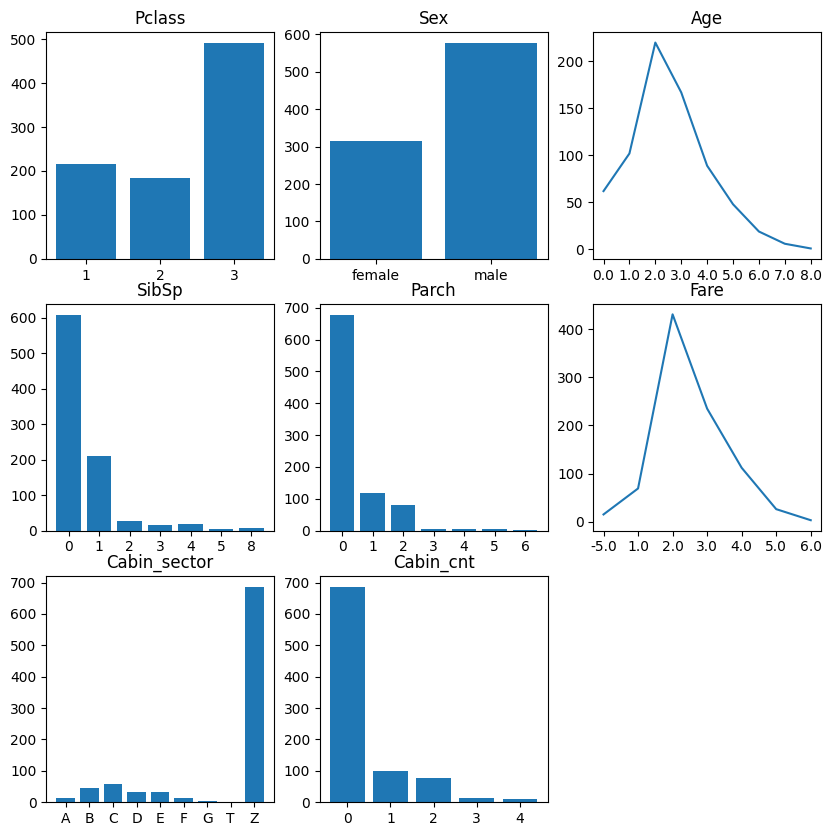

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
for i ,col in enumerate(train_x.columns):
  plt.subplot(3,3,i+1)
  val_count = train_x[col].value_counts().sort_index()
  if col == 'Age' or col == 'Fare':
    plt.plot(range(len(val_count)), val_count)
  else:
    plt.bar(range(len(val_count)),val_count)
  plt.xticks(range(len(val_count)), val_count.index)
  plt.title(col)
plt.show()

PClass와 Cabin_sector의 연관성이 높은 것을 확인


<Axes: >

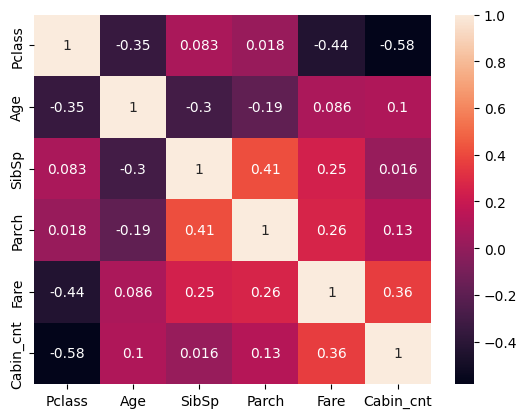

In [ ]:
import seaborn as sns
sns.heatmap(train_x.corr(), annot=True)

## Preprocessing missing values

In [ ]:
# count nan
train_x.count()

Pclass          891
Sex             891
Age             714
SibSp           891
Parch           891
Fare            891
Cabin_sector    891
Cabin_cnt       891
dtype: int64

In [ ]:
train_x['Age'].fillna(-1, inplace = True)
test_x['Age'].fillna(-1, inplace = True)

train_x.fillna(-1,inplace = True)
test_x.fillna(-1,inplace = True)

## Transform Cateforical values to label values

In [ ]:
categorical_columns = ['Sex','Cabin_sector']

for col in categorical_columns:
  le = LabelEncoder()
  train_x[col] = le.fit_transform(train_x[col])
  test_x[col] = le.fit_transform(test_x[col])

# Training

Use LightGBM for training

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
model = lgb.LGBMClassifier(
    n_jobs = -1, 
    random_seed = 42,
    boosting_type = 'gbdt',
    objective = 'binary',
    learning_rate = 0.03,
    num_leaves = 63,
    max_depth = None,
    n_estimators = 100
    )

model_rf = RandomForestClassifier(
    n_jobs = -1,
    max_depth = None,
    min_samples_split = 10
    )

model_li = LogisticRegression(
    penalty = 'l2',
    random_state = 42,
    class_weight = 'balanced'
)
param = {
    'min_child_samples' : [10,16]
}
param_rf = {
    'min_samples_leaf' : [4,6,8]
}
param_li = {
    'C' : [1.0,0.9,0.7],
    'solver' : ['lbfgs', 'liblinear','newton-cg'],
    'max_iter' : [100,300,500]
}

grid_search= GridSearchCV(model, param_grid=param, cv=5, refit=True)
grid_search.fit(train_x,train_y)

print(f'GridSearchCV 최적 파라미터: { grid_search.best_params_ }')
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

grid_search_rf= GridSearchCV(model_rf, param_grid=param_rf, cv=5, refit=True)
grid_search_rf.fit(train_x,train_y)

print(f'GridSearchCV 최적 파라미터: { grid_search_rf.best_params_ }')
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search_rf.best_score_))

grid_search_li= GridSearchCV(model_li, param_grid=param_li, cv=5, refit=True)
grid_search_li.fit(train_x,train_y)

print(f'GridSearchCV 최적 파라미터: { grid_search_li.best_params_ }')
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search_li.best_score_))

GridSearchCV 최적 파라미터: {'min_child_samples': 10}
GridSearchCV 최고 정확도:0.8317
GridSearchCV 최적 파라미터: {'min_samples_leaf': 4}
GridSearchCV 최고 정확도:0.8126
GridSearchCV 최적 파라미터: {'C': 0.9, 'max_iter': 100, 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.7733


# Inference

In [ ]:
estimator = grid_search.best_estimator_
pred_lgbm = estimator.predict_proba(test_x)
estimator_rf = grid_search_rf.best_estimator_
pred_rf = estimator_rf.predict_proba(test_x)
estimator_li = grid_search_li.best_estimator_
pred_li = estimator_li.predict_proba(test_x)
pred = []
for i in range(len(pred_lgbm)):
  pred.append([(pred_lgbm[i][0] + pred_rf[i][0] + pred_li[i][0])/3, (pred_lgbm[i][1] + pred_rf[i][1] + pred_li[i][1])/3])
pred = np.array(pred).reshape(-1,2)
pred = np.argmax(pred, axis = 1)

In [ ]:
ans_df = pd.DataFrame(columns =['PassengerId', 'Survived'], index = test_df.index)
ans_df['PassengerId'] = test_df['PassengerId']
ans_df['Survived'] = pred

In [ ]:
ans_df.to_csv('submission.csv', index = False)

In [ ]:
df = pd.read_csv('./submission.csv')
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
